In [1]:
### I changed the tss region from 2000bp to 3000bp in the source code
### /disk1/pengweixing/software/SnapATAC2/snapatac2-python
### install with pip install .

In [5]:
import scanpy as sc
import scipy
import snapatac2 as snap
import matplotlib.pyplot as plt

In [6]:
import matplotlib

In [7]:
import importlib

In [8]:
import pandas as pd
import numpy as np

In [9]:
print(snap.__version__)

2.7.1.dev0


In [43]:
fragment_file = "Spleen_Unique500_FRiT15_selected.singlecell.fragments.gz"

In [44]:
%%time
adata = snap.pp.import_data(
    fragment_file,
    chrom_sizes=snap.genome.mm10,
  #  file="spleen.h5ad",  # Optional
    sorted_by_barcode=False,
)

CPU times: user 6min 4s, sys: 44.7 s, total: 6min 48s
Wall time: 2min 36s


In [48]:
snap.metrics.tsse(adata, snap.genome.mm10)

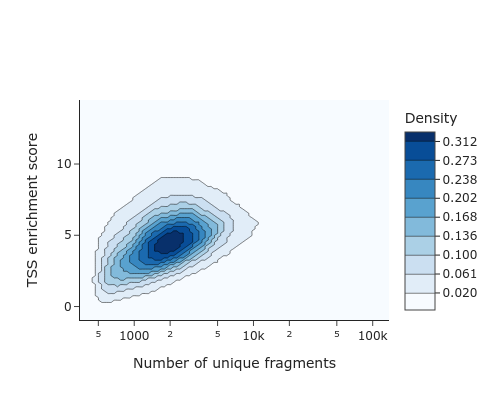

In [49]:
snap.pl.tsse(adata, interactive=False, show=True
             #out_file="Umap/tsse_plot.pdf"
            )

In [50]:
tss = snap.pl.tsse(adata, interactive=False, show=False, out_file=None)

In [51]:
import plotly.graph_objs as go
tss2 = go.Figure(tss)

In [52]:
tss2.add_shape(
    type="line",
    y0=4,
    y1=4,
    x0=0,        # Start at the left edge of the plot
    x1=1,        # End at the right edge of the plot
    xref='paper',  # Use 'paper' to make the line span the full plot width
    yref='y',      # Use 'y' to refer to the y-axis scale
    line=dict(color="Black", width=2, dash="dash")
)
tss2.add_shape(
    type="line",
    x0=1500,        # Set x-coordinate where the vertical line will be drawn
    x1=1500,
    y0=0,        # Start at the bottom of the y-axis
    y1=1,        # End at the top of the y-axis
    xref='x',    # Use x-axis scale for x0 and x1
    yref='paper',  # Use paper to span the full height of the plot
    line=dict(color="Black", width=2, dash="dash")
)

tss2.update_layout(
    xaxis=dict(
        range=[3, 5]  # Set x-axis range
    ),
    yaxis=dict(
        range=[0, 25]  # Set x-axis range
    )
)
tss2.write_image("Umap/scFFPE_spleen.TSS.pdf")

In [21]:
adata.obs.to_csv("differentialpeaks/obs.raw.txt",sep="\t")

In [ ]:
adata.write('adata_all.h5ad')

In [10]:
adata = snap.read('adata_all.h5ad')

In [53]:
adata = adata.to_memory()

In [54]:
adata

AnnData object with n_obs × n_vars = 29418 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [55]:
adata2 = adata.copy()

In [56]:
snap.pp.filter_cells(adata2, min_counts=500, min_tsse=4, max_counts=100000,inplace=True)

CPU times: user 593 ms, sys: 19.7 s, total: 20.3 s
Wall time: 20.3 s


In [59]:
adata_5K = snap.pp.add_tile_matrix(adata2,bin_size=5000,inplace = False)

In [77]:
adata2

AnnData object with n_obs × n_vars = 18640 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [60]:
np.median(adata_5K.obs['tsse'])

5.405405405405405

In [61]:
#matrix = adata_5K_memory.X
#nonzero_counts = np.asarray((matrix > 0).sum(axis=0))
#vars_to_keep = nonzero_counts >= 10
#adata_filtered_5K = adata_5K_memory[:, vars_to_keep]

### remove doublets

In [84]:
snap.pp.select_features(adata_5K, n_features=250000)

2025-03-10 16:50:31 - INFO - Selected 250000 features.


In [85]:
snap.pp.scrublet(adata_5K)

2025-03-10 16:50:40 - INFO - Simulating doublets...
2025-03-10 16:51:15 - INFO - Spectral embedding ...
2025-03-10 16:57:37 - INFO - Calculating doublet scores...


In [86]:
snap.pp.filter_doublets(adata_5K)

2025-03-10 16:57:53 - INFO - Detected doublet rate = 0.000%


### assign the fragments to adata_scaled

In [87]:
cellnames = adata_5K.obs.index  

In [88]:
cellnames

Index(['AAAGGAAAGGCAATA_Tn5_25', 'AAAGGAAAGGCCCTT_Tn5_23',
       'AAAGGAAAGGGTGCC_Tn5_1', 'AAAGGAACACACATA_Tn5_8',
       'AAAGGAACACAGATG_Tn5_37', 'AAAGGAACACTACCT_Tn5_32',
       'AAAGGAACTCCGTTT_Tn5_19', 'AAAGGAACTCGTGTA_Tn5_35',
       'AAAGGAAGAAAACAC_Tn5_38', 'AAAGGAAGAAAAGGG_Tn5_31',
       ...
       'TTTCCTGTCGGGATA_Tn5_37', 'TTTCCTGTCGGTCAC_Tn5_15',
       'TTTCCTGTCGTCGAT_Tn5_3', 'TTTCCTTACGAACAC_Tn5_40',
       'TTTCCTTACGATCCA_Tn5_31', 'TTTCCTTACGTAACC_Tn5_20',
       'TTTCCTTACGTGCAA_Tn5_16', 'TTTCCTTACGTGCTT_Tn5_34',
       'TTTCCTTATGCAATA_Tn5_8', 'TTTCCTTTCCGAGGT_Tn5_21'],
      dtype='object', length=16778)

In [89]:
adata_memory = adata.to_memory()

In [90]:
adata_5K.obsm['fragment_paired'] = adata_memory[cellnames,:].obsm['fragment_paired']
adata_5K.uns['reference_sequences']  = adata_memory.uns['reference_sequences']

### dimention reduction and clustering

In [91]:
adata_5K

AnnData object with n_obs × n_vars = 16778 × 526765
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'scrublet_sim_doublet_score', 'doublet_rate', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [92]:
snap.pp.select_features(adata_5K,n_features=250000)

2025-03-10 16:58:25 - INFO - Selected 250000 features.


In [93]:
snap.tl.spectral(adata_5K)

In [94]:
snap.tl.umap(adata_5K,use_rep='X_spectral',n_neighbors = 20,min_dist =0.2)

/disk1/pengweixing/software/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/disk1/pengweixing/software/miniconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [95]:
snap.pp.knn(adata_5K)

In [96]:
adata_5K.obs

,n_fragment,frac_dup,frac_mito,tsse,doublet_probability,doublet_score,leiden
AAAGGAAAGGCAATA_Tn5_25,1475,0.0,0.004723,5.764967,8.328833e-236,0.003591,1
AAAGGAAAGGCCCTT_Tn5_23,1534,0.0,0.003896,4.132231,6.304445e-237,0.001445,1
AAAGGAAAGGGTGCC_Tn5_1,2028,0.0,0.007828,4.261364,2.196546e-237,0.000569,1
AAAGGAACACACATA_Tn5_8,2126,0.0,0.008396,4.479578,4.597780e-234,0.006936,0
AAAGGAACACAGATG_Tn5_37,2262,0.0,0.006151,4.415584,2.364101e-190,0.095344,1
...,...,...,...,...,...,...,...
TTTCCTTACGTAACC_Tn5_20,5616,0.0,0.008124,4.470939,1.219347e-200,0.073698,0
TTTCCTTACGTGCAA_Tn5_16,4688,0.0,0.006359,5.437553,8.903426e-227,0.021065,0
TTTCCTTACGTGCTT_Tn5_34,3933,0.0,0.017241,6.672227,1.517650e-186,0.103502,1
TTTCCTTATGCAATA_Tn5_8,2992,0.0,0.001335,4.372842,1.464604e-227,0.019534,0


In [97]:
snap.tl.leiden(adata_5K,resolution = 0.3)

In [98]:
adata_5K

AnnData object with n_obs × n_vars = 16778 × 526765
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'scrublet_sim_doublet_score', 'doublet_rate', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [99]:
# custom_colors = {'0':'green', '1':'#ff7f0e', '2':'#2ca02c', '3':'red'}

In [100]:
replace_dict = {'0':'Bcell','1': 'Tcell', '2': 'MyeloidCell', '3': 'MyeloidCell','4':'MyeloidCell'}
adata_5K.obs['CellType'] = adata_5K.obs['leiden'].replace(replace_dict)

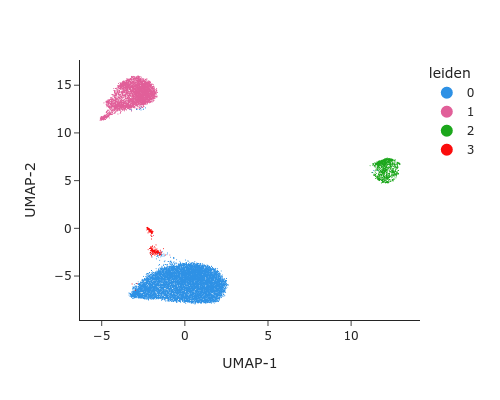

In [101]:
snap.pl.umap(adata_5K, color='leiden',interactive=False,width=500,use_rep = 'X_umap',
           # out_file="umap.pdf"
            )

In [ ]:
snap.pl.umap(adata_5K, color='CellType',interactive=False,width=500,use_rep = 'X_umap',
           # out_file="umap.pdf"
            )

In [33]:
obs = adata_5K.obs

In [34]:
obs['umapx'] = pd.DataFrame(adata_5K.obsm['X_umap'])[0].to_list()

In [35]:
obs['umapy'] = pd.DataFrame(adata_5K.obsm['X_umap'])[1].to_list()

In [36]:
obs

,n_fragment,frac_dup,frac_mito,tsse,doublet_probability,doublet_score,leiden,CellType,umapx,umapy
AAAGGAAAGGCCCTT_Tn5_23,1534,0.0,0.003896,4.132231,0.321386,0.000312,1,Tcell,1.981377,10.959730
AAAGGAAAGGGTGCC_Tn5_1,2028,0.0,0.007828,4.261364,0.321386,0.000312,1,Tcell,1.059513,12.129503
AAAGGAACACACATA_Tn5_8,2126,0.0,0.008396,4.479578,0.321386,0.000312,0,Bcell,2.594244,-4.740311
AAAGGAACACAGATG_Tn5_37,2262,0.0,0.006151,4.415584,0.321386,0.000312,1,Tcell,1.605365,12.088725
AAAGGAACTCCGTTT_Tn5_19,3140,0.0,0.016599,5.827506,0.295345,0.006173,0,Bcell,5.914005,-3.457837
...,...,...,...,...,...,...,...,...,...,...
TTTCCTTACGTAACC_Tn5_20,5616,0.0,0.008124,4.470939,0.210022,0.048864,0,Bcell,6.582300,-4.029111
TTTCCTTACGTGCAA_Tn5_16,4688,0.0,0.006359,5.437553,0.266077,0.014269,0,Bcell,7.116513,-2.712618
TTTCCTTACGTGCTT_Tn5_34,3933,0.0,0.017241,6.672227,0.209444,0.053191,1,Tcell,2.665359,12.784590
TTTCCTTATGCAATA_Tn5_8,2992,0.0,0.001335,4.372842,0.293798,0.006554,0,Bcell,4.172431,-3.228538


In [65]:
obs.to_csv("differentialpeaks/obs2.txt",sep="\t")

In [37]:
adata_5K.write('adata_5K.h5ad')

... storing 'leiden' as categorical
... storing 'CellType' as categorical


In [38]:
adata_5K = snap.read('adata_5K.h5ad')

### Gene activity

In [74]:
%%time
gene_matrix = snap.pp.make_gene_matrix(adata_5K, snap.genome.mm10,
                                      upstream=5000, downstream=500)

CPU times: user 2min 47s, sys: 6.43 s, total: 2min 54s
Wall time: 13.6 s


In [75]:
gene_matrix

AnnData object with n_obs × n_vars = 12734 × 55291
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'CellType', 'umapx', 'umapy'

In [76]:
gene_matrix.obsm["X_umap"] = adata_5K.obsm["X_umap"]

In [77]:
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

In [78]:
sc.external.pp.magic(gene_matrix, solver="approximate")

In [79]:
gene_matrix

AnnData object with n_obs × n_vars = 12734 × 52329
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'CellType', 'umapx', 'umapy'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [84]:
marker_genes  =  [
    "Cd19", # B_cell
    "Cd3e", # T cells
    "Tppp3",'Vcam1',#Mono
  #  "Col5a1"#Erythroid
]

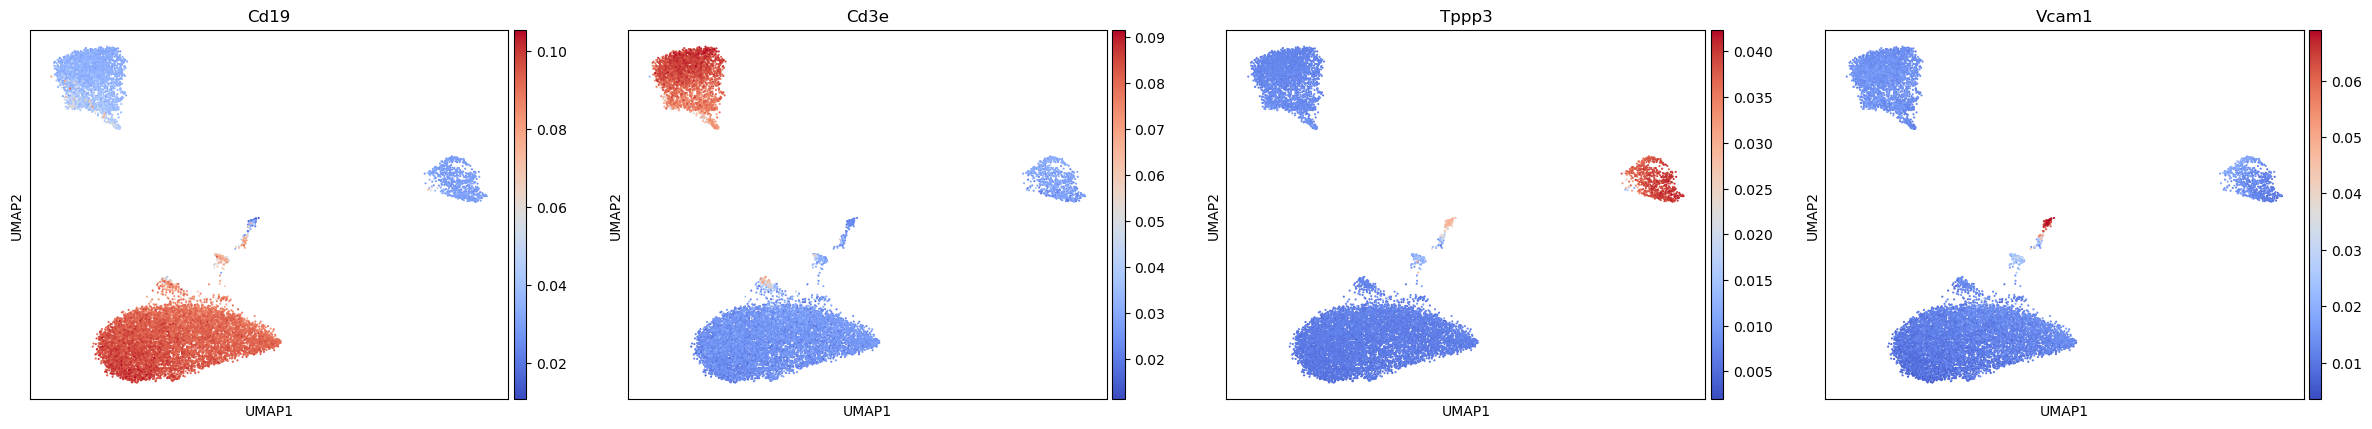

In [85]:
a = sc.pl.umap(gene_matrix, use_raw=False, color= marker_genes,color_map=plt.cm.coolwarm,
           ncols=4,save="differentialgenes/Geneactivity.pdf" )

In [86]:
a

In [87]:
gene_matrix.write('gene_matrix.h5ad')

In [39]:
gene_matrix = snap.read('gene_matrix.h5ad')

### differential genes

In [88]:
allcodinggene = pd.read_csv('/disk1/pengweixing/database/mm10/protein_coding.rmmt.txt')

In [89]:
sc.pp.highly_variable_genes(gene_matrix, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [90]:
gene_matrix.raw = gene_matrix

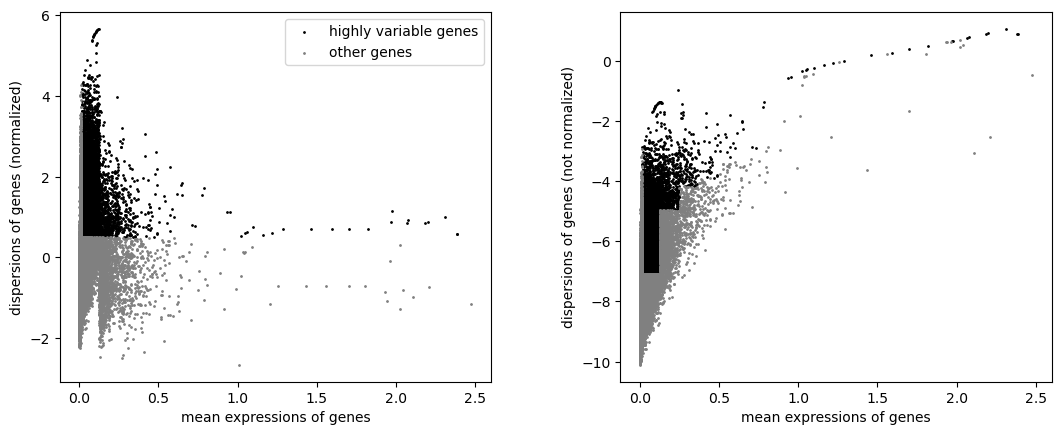

In [91]:
sc.pl.highly_variable_genes(gene_matrix)

In [92]:
variablegenes = gene_matrix.var.highly_variable[gene_matrix.var.highly_variable==True]

In [93]:
isct_genes = allcodinggene['gene'][allcodinggene['gene'].isin(variablegenes.index)]

In [94]:
gene_matrix.var['highly_variable_coding'] = gene_matrix.var.index.isin(isct_genes)

In [95]:
gene_matrix.write('gene_matrix_differential.h5ad')

In [8]:
gene_matrix = sc.read_h5ad('gene_matrix_differential.h5ad')

In [9]:
gene_matrix2 = gene_matrix[:, gene_matrix.var.highly_variable_coding]

In [10]:
gene_matrix2.raw = gene_matrix2

In [52]:
gene_matrix2

AnnData object with n_obs × n_vars = 12734 × 6737
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'CellType', 'umapx', 'umapy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_coding', 'mean', 'std'
    uns: 'hvg', 'log1p', 'rank_genes_groups'
    obsm: 'X_umap'

In [11]:
sc.pp.regress_out(gene_matrix2, ["n_fragment", "frac_mito"])

In [12]:
sc.pp.scale(gene_matrix2)

In [13]:
sc.tl.rank_genes_groups(gene_matrix2, "CellType", method="t-test")

In [14]:
gene_matrix2.write('gene_matrix2.h5ad')

In [41]:
gene_matrix2 = snap.read('gene_matrix2.h5ad')

In [15]:
to20markergenes = pd.DataFrame(gene_matrix2.uns["rank_genes_groups"]["names"]).head(30)

In [16]:
for index in to20markergenes.columns:
    print('Cluster',index,to20markergenes[index].to_list(),sep="\t")
    print('\n')

Cluster	Bcell	['Ebf1', 'Pax5', 'Chst3', 'Vmn2r27', 'Blnk', 'Fcrl1', 'Pigr', 'Blk', 'Farsb', 'Rgs13', 'Kmo', 'Ccr6', 'Bank1', 'Kcnj1', 'Serpinb7', 'Cd19', 'Fcmr', 'Fam167a', 'Napsa', 'Cr2', 'Il5ra', 'Txndc11', 'Smpd3', 'Cd74', 'Pik3c2b', 'Kcnmb3', 'Hfm1', 'Gad1', 'Gm14548', 'Ciita']


Cluster	MyeloidCell	['Hacd4', 'Chrdl1', 'Pik3cb', 'Tcerg1l', 'Dhrs3', 'Vwc2', 'Cpa6', 'Kif21a', 'Macc1', 'Grm1', 'Fap', 'Abcb5', 'Ptpre', 'Zeb2', 'Abca6', 'Rnf144b', 'Bmpr1b', 'Phex', 'Rab38', 'Dpp6', 'Slc15a5', 'Scarb1', 'Angpt1', 'Spock1', 'Col4a5', 'Abca9', 'Tmtc1', 'Otogl', 'Onecut2', 'Npr3']


Cluster	Tcell	['Rnf125', 'Sytl2', 'Cd226', 'Il18r1', 'Gata3', 'Atp6v0d2', 'Icos', 'Prkch', 'Fbxo27', 'Podnl1', 'Ppm1j', 'Gpr68', 'Igsf23', 'Gpc1', 'Atp10a', 'Arl4c', 'Sctr', 'Nck2', 'Leprotl1', 'Sla2', 'Nt5e', 'Skap1', 'Gm17509', 'Wscd2', 'Gm11077', 'Rgs1', 'Glb1', 'Ccdc148', 'Clec3b', 'Galnt2']




In [1]:
gene_matrix_exp = pd.DataFrame(gene_matrix2.X)
gene_matrix_exp.columns = gene_matrix2.var.index
gene_matrix_exp.index = gene_matrix.obs.index

NameError: name 'pd' is not defined

In [247]:
import pandas as pd
allnames = ['Tcell','Bcell', 'MyeloidCell']
# Assuming gene_matrix2 is defined and accessible
gene_matrix_exp_reorder = pd.DataFrame()
with pd.ExcelWriter("Genedifferential.xlsx", engine="openpyxl") as f:
    for i in allnames:
        print(f"Processing sheet {i}")
        
        # Extract relevant data
        padj = pd.DataFrame(gene_matrix2.uns["rank_genes_groups"]['pvals_adj']).loc[:, i]
        logfoldchanges = pd.DataFrame(gene_matrix2.uns["rank_genes_groups"]['logfoldchanges']).loc[:, i]
        names = pd.DataFrame(gene_matrix2.uns["rank_genes_groups"]['names']).loc[:, i]
        
        # Create the DataFrame
        empty_df = pd.DataFrame({
            "padj": padj,
            "LogFC": logfoldchanges,
            "Names": names
        })
        filtered_df = empty_df[(empty_df['padj'] < 0.05) & (empty_df['LogFC'] > 0.25)]
        # Ensure sheet name is correctly formatted and valid
        sheet_name = str(i)  # or simply str(i) for simpler names
        temp = gene_matrix_exp.loc[:,filtered_df['Names']]
        gene_matrix_exp_reorder = pd.concat([gene_matrix_exp_reorder, temp], axis=1)

        # Write DataFrame to the sheet
        filtered_df.to_excel(f, sheet_name=sheet_name, index=False)
        
print("Excel file written successfully.")


Processing sheet Tcell
Processing sheet Bcell
Processing sheet MyeloidCell
Excel file written successfully.


### take the mean value of gene expression for each celltyp

In [248]:
gene_matrix_exp_reorder.index = gene_matrix.obs.index
gene_matrix_exp_reorder.head(n=5)
mean_mtx = pd.DataFrame(index=range(gene_matrix_exp_reorder.shape[1]), columns=gene_matrix.obs['CellType'].unique().to_list())

In [160]:
mean_mtx.index = gene_matrix_exp_reorder.columns

In [161]:
for each in gene_matrix.obs['CellType'].unique().to_list():
    temp_bool = gene_matrix.obs['CellType'] == each
    temp_matrix = gene_matrix_exp_reorder.loc[temp_bool,:]
    column_sums = temp_matrix.sum(axis=0)
    column_means = column_sums / temp_matrix.shape[0]
    column_means = np.array(column_means).flatten()
    mean_mtx[each] = column_means

In [171]:
mean_mtx_unique = mean_mtx[~mean_mtx.index.duplicated(keep='first')]
mean_mtx.to_csv("gene_exp_mean_reorder.txt",sep="\t")

### plot top10 marker genes

In [122]:
Ttop10genes = to20markergenes['Tcell'][0:10].tolist()
Ttop10genes.extend(to20markergenes['Bcell'][0:10].tolist())
Ttop10genes.extend(to20markergenes['MyeloidCell'][0:10].tolist())

In [ ]:
#plt.figure(figsize=(25, 12)) # You can adjust the size (width, height) as needed
sc.pl.umap(gene_matrix, use_raw=False, color= to20markergenes['Tcell'][0:10],save="differentialgenes/scFFPE.Tcell.Top10.pdf",
           color_map=plt.cm.coolwarm,ncols=4 )

In [ ]:
#plt.figure(figsize=(25, 12)) # You can adjust the size (width, height) as needed
sc.pl.umap(gene_matrix, use_raw=False, color= to20markergenes['Bcell'][0:10],save="differentialgenes/scFFPE.Bcell.Top10.pdf",
           color_map=plt.cm.coolwarm,ncols=4 )

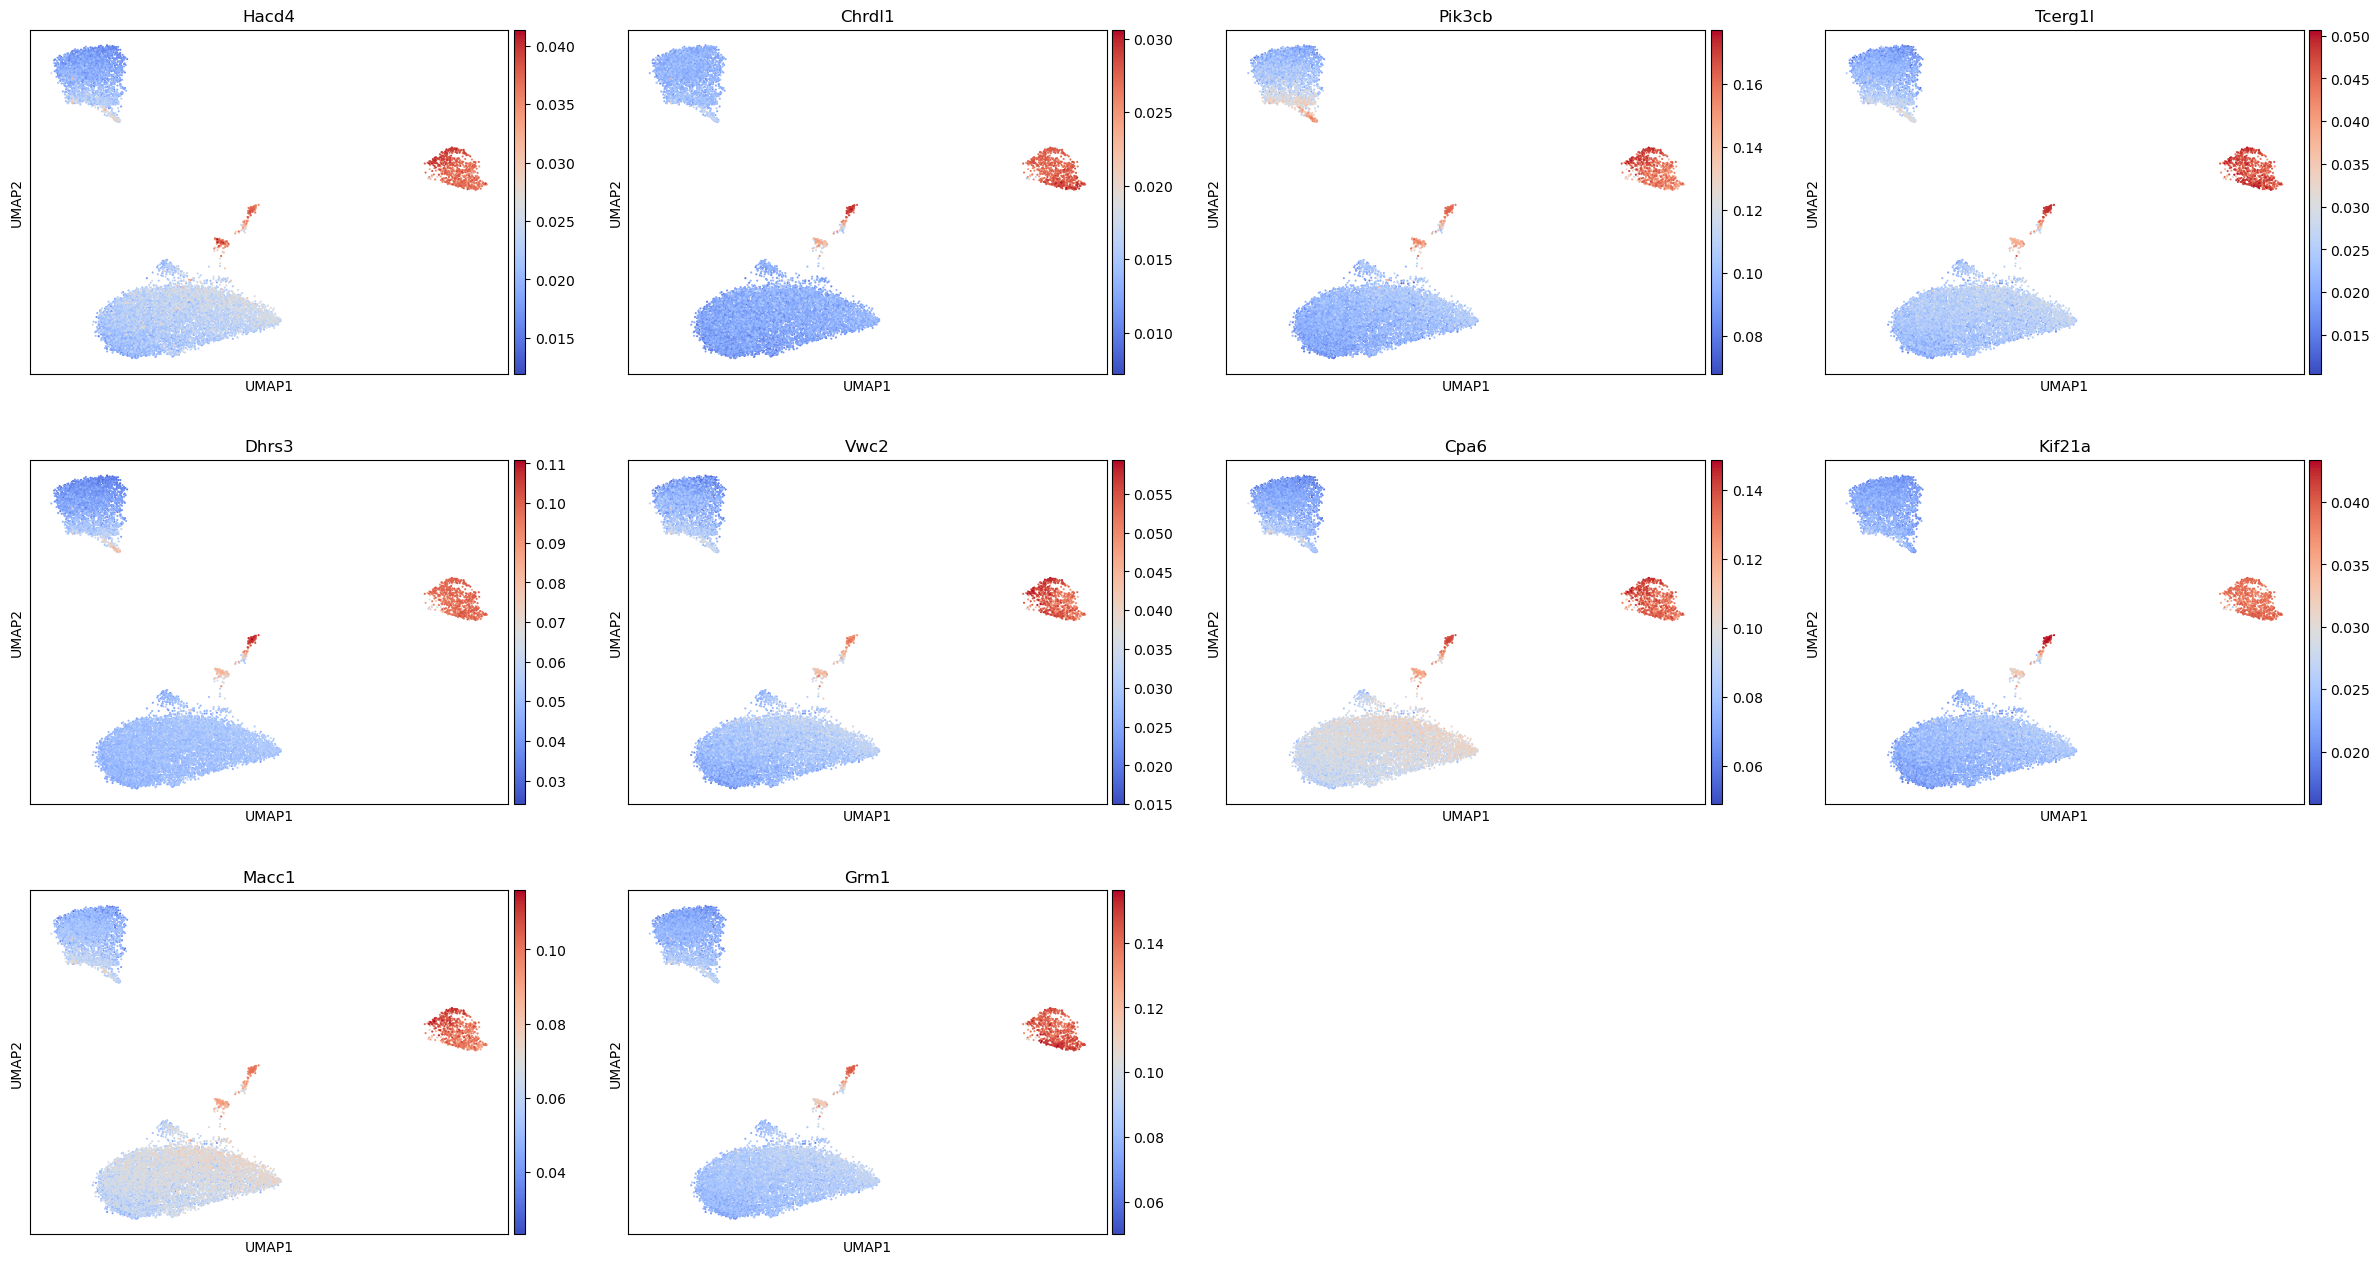

In [133]:
#plt.figure(figsize=(25, 12)) # You can adjust the size (width, height) as needed
sc.pl.umap(gene_matrix, use_raw=False, color= to20markergenes['MyeloidCell'][0:10],save="differentialgenes/scFFPE.MyeloidCell.Top10.pdf",
           color_map=plt.cm.coolwarm,ncols=4 )

## peak calling in default

In [8]:
snap.tl.macs3(adata_5K, groupby='CellType')

2025-01-11 15:49:23 - INFO - Exporting fragments...
2025-01-11 15:49:49 - INFO - Calling peaks...
100%|██████████| 3/3 [04:55<00:00, 98.66s/it] 


In [9]:
peaks = snap.tl.merge_peaks(adata_5K.uns['macs3'], snap.genome.mm10,half_width=500)
peaks.head()

/disk1/pengweixing/tmp/ipykernel_54429/1134248046.py:1: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  peaks = snap.tl.merge_peaks(adata_5K.uns['macs3'], snap.genome.mm10,half_width=500)


Peaks,Tcell,Bcell,MyeloidCell
str,bool,bool,bool
"""chr1:3141371-3142372""",false,true,false
"""chr1:3709185-3710186""",false,true,false
"""chr1:3783778-3784779""",false,true,false
"""chr1:4622895-4623896""",true,true,true
"""chr1:4747783-4748784""",true,false,false


In [10]:
peaks2 = pd.DataFrame(peaks)

In [11]:
selected_peaks = peaks2[peaks2.iloc[:, 1:].sum(axis=1) == 1]

In [12]:
selected_peaks.columns = peaks.columns

In [13]:
peak_mat = snap.pp.make_peak_matrix(adata_5K, use_rep=peaks['Peaks'])

/disk1/pengweixing/software/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
matrix = peak_mat.X
nonzero_counts = np.asarray((matrix > 0).sum(axis=0))
vars_to_keep = nonzero_counts >= 10
peak_mat_filter = peak_mat[:, vars_to_keep]

In [15]:
peak_mat.write_h5ad("peak500_matrix.h5ad")

In [7]:
peak_mat  = snap.read('peak500_matrix.h5ad')

In [13]:
with open('ffpe.total.peaks.bed','w') as f:
    for each in peak_mat.var_names:
        each2 = each.replace(':','\t').replace('-','\t')
        f.write('%s\n' % each2)

In [1]:
140+125

265

In [2]:
180+125

305